In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr

In [2]:
plt.rcParams["image.interpolation"] = "nearest"

In [3]:
%matplotlib widget

In [4]:
# -- get spectra
specs13 = np.load("../output/hsi0_overlap_cnn_allwave_bridge.npy").T

# -- load spec location
loc13 = np.load("../output/hsi0_overlap_location_bridge.npy")

# -- load waves range for both scans
waves13 = np.load("../output/graham_hall_upload/cube0_waves_range.npy")
waves18 = np.load("../output/graham_hall_upload/cube1_waves_range.npy")

# -- load templates, waves, and names
templs = np.load("../output/final_spectra_20.npy")
names = np.load("../output/final_name_20.npy")
wavest = np.load("../output/graham_hall_upload/lspdd_lab_spectra_wavelengths.npy")

In [5]:
# -- get quantum efficiency
qe = pd.read_csv("../data/hsi1-qe.csv", delimiter="\t")

In [6]:
qe

,wavelength_nm,quantum_efficiency
0,399.554566,32.007648
1,400.000000,32.007648
2,400.445434,32.007648
3,400.890869,32.237094
4,401.336303,32.237094
...,...,...
1341,996.881960,3.671128
1342,997.327394,3.671128
1343,997.772828,3.441683
1344,998.218263,3.441683


<AxesSubplot:xlabel='wavelength_nm'>

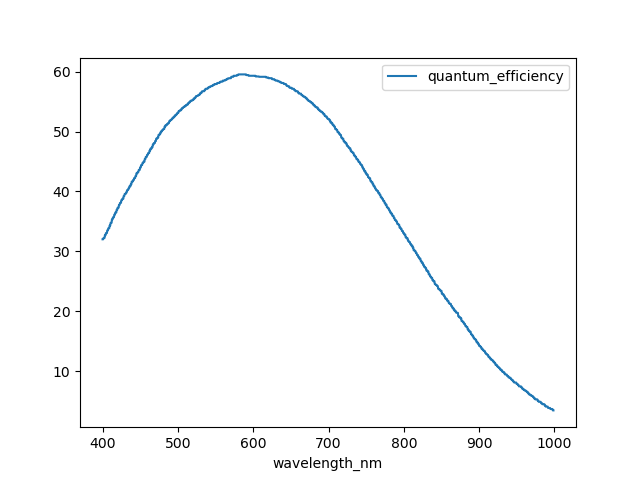

In [7]:
plt.close("all")
qe.plot("wavelength_nm", "quantum_efficiency")

In [8]:
# -- interpolate 2013 onto 2018
specs13in = np.array([np.interp(waves18, waves13, i) for i in specs13])
templsin = np.array([np.interp(waves18, wavest, i) for i in templs])
qe = np.interp(waves18, qe["wavelength_nm"], qe["quantum_efficiency"]) * 0.01

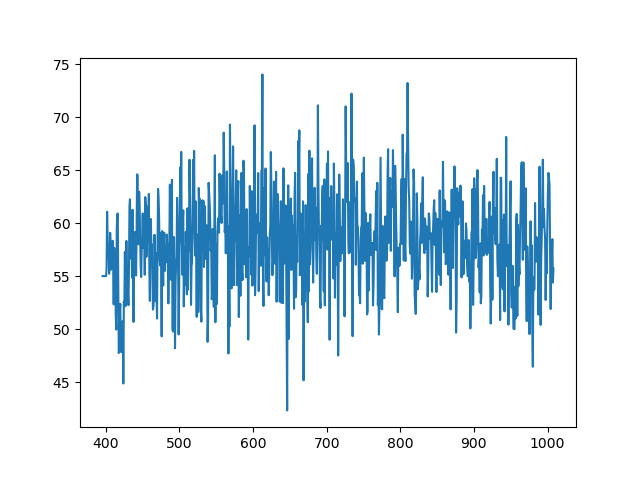

In [9]:
plt.close("all")
plt.plot(waves18, specs13in[0])

In [10]:
# -- find the noise levels (note we are overestimating b/c of signal looks like about 10%)
sig = np.median(specs13in.std(axis=1)) / 1.1

In [11]:
# -- for each spectrumt get chi^2
slp, off = np.polyfit(waves18, specs13in.T, 1)
model = (slp * waves18[:, None] + off).T
chisq = ((specs13in - model)**2 / sig**2).mean(axis=1)

In [12]:
# -- subset spectra
chisq_thr = 1.2
specs13in = specs13in[chisq > chisq_thr]

In [14]:
# -- "correct" templates for QE
templsinqe = templsin * qe

In [15]:
# -- standardize
stand2d = lambda x: (x - x.mean(axis=1, keepdims=True)) / x.std(axis=1, keepdims=True)
specs13inst = stand2d(specs13in)
templsinst = stand2d(templsin)
templsinqest = stand2d(templsinqe)

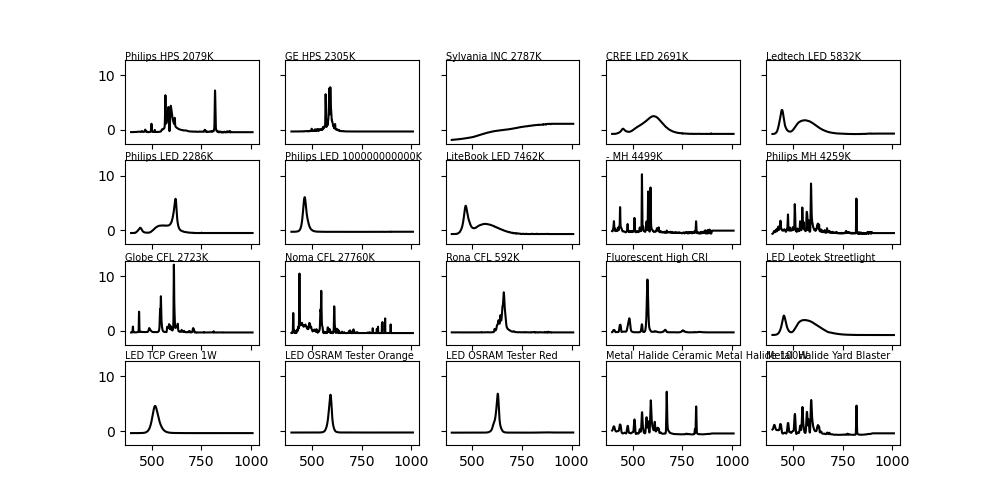

In [16]:
plt.close("all")
fig, ax = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(10, 5))
for ii in range(20):
    ax[ii // 5, ii % 5].plot(waves18, templsinst[ii], "k")
    ax[ii // 5, ii % 5].set_title(names[ii], loc="left", fontsize=7, va="top")

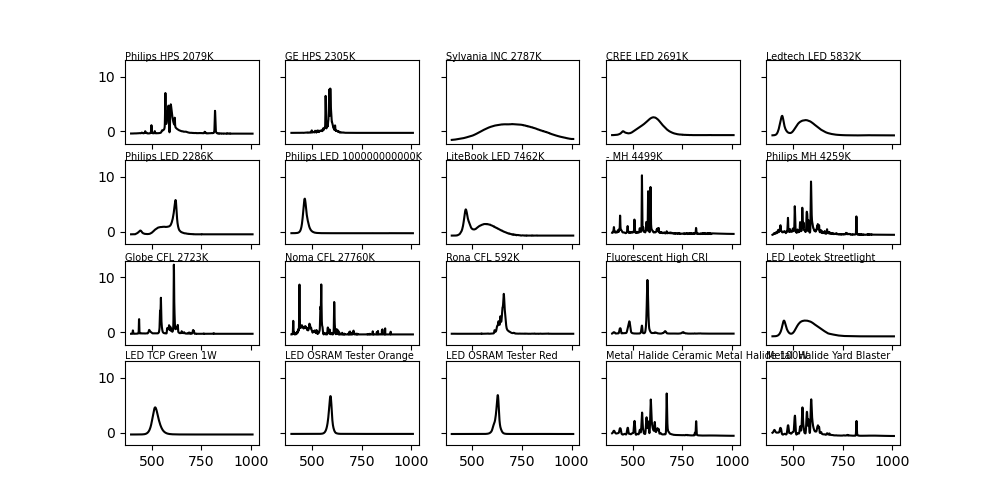

In [17]:
plt.close("all")
fig, ax = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(10, 5))
for ii in range(20):
    ax[ii // 5, ii % 5].plot(waves18, templsinqest[ii], "k")
    ax[ii // 5, ii % 5].set_title(names[ii], loc="left", fontsize=7, va="top")

In [18]:
# -- get the correlation coefficients
ccs = np.dot(specs13inst, templsinqest.T) / specs13inst.shape[1]
labs = ccs.argmax(axis=1)

In [21]:
tinds = np.where(ccs.argmax(axis=1) == 2)[0]

In [22]:
tinds.shape

(501,)

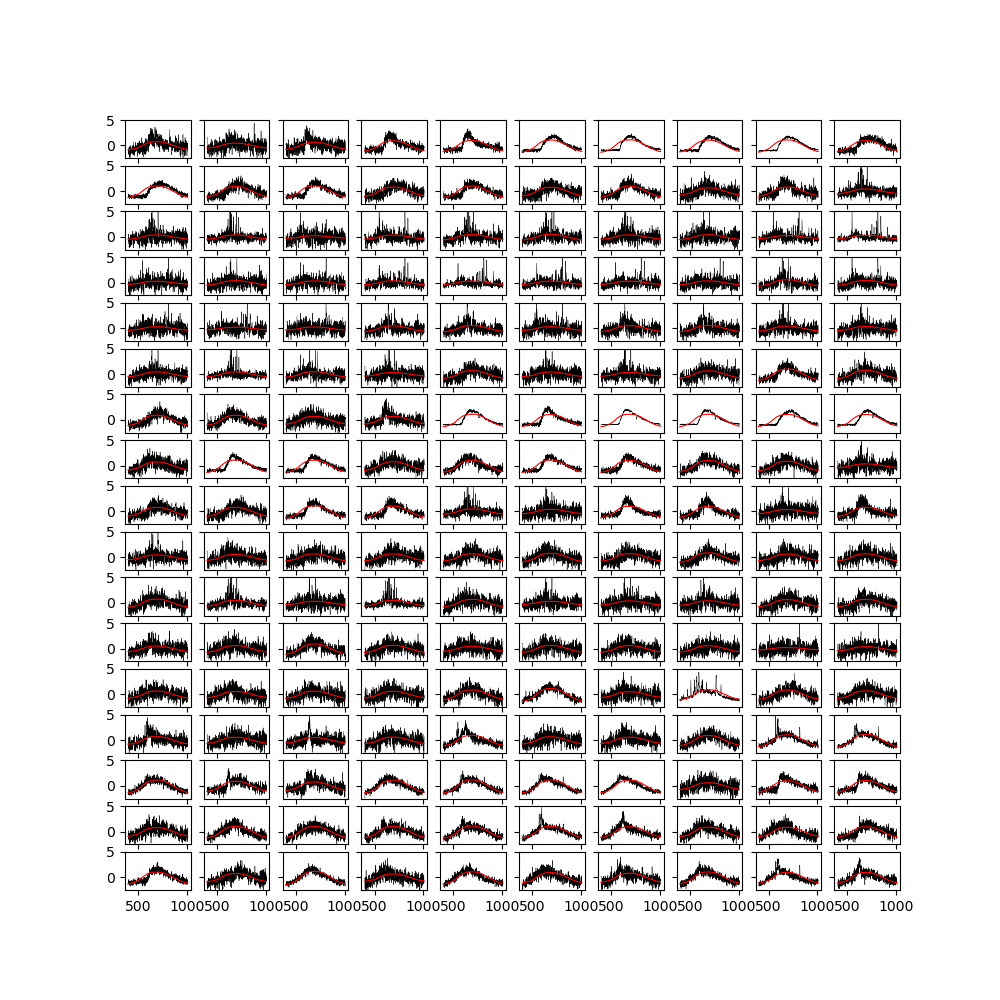

In [176]:
tinds = np.where(ccs.argmax(axis=1) == 2)[0]
plt.close("all")
fig, ax = plt.subplots(17, 10, sharex=True, sharey=True, figsize=(10, 10))
for ii in range(170):
    tax = ax[ii // 10, ii % 10]
    tax.plot(waves18, specs13inst[tinds[ii]], "k", lw=0.3)
    tax.plot(waves18, ccs[tinds[ii], 2] * templsinqest[2], "r", lw=0.8)
    tax.set_ylim(-2.5, 5.0)

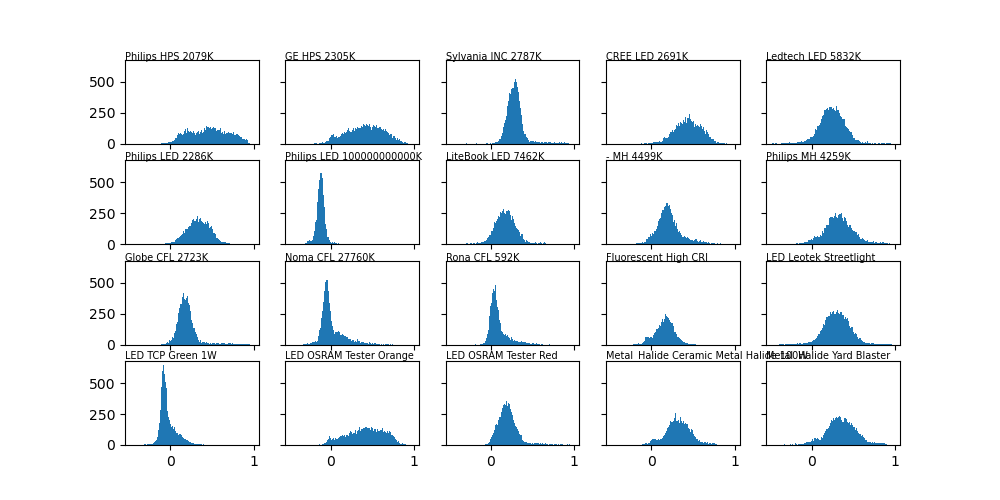

In [23]:
# -- make histograms of correlations
plt.close("all")
fig, ax = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(10, 5))
for ii in range(20):
    ax[ii // 5, ii % 5].hist(ccs[:, ii], bins=100)
    ax[ii // 5, ii % 5].set_title(names[ii], loc="left", fontsize=7, va="top")

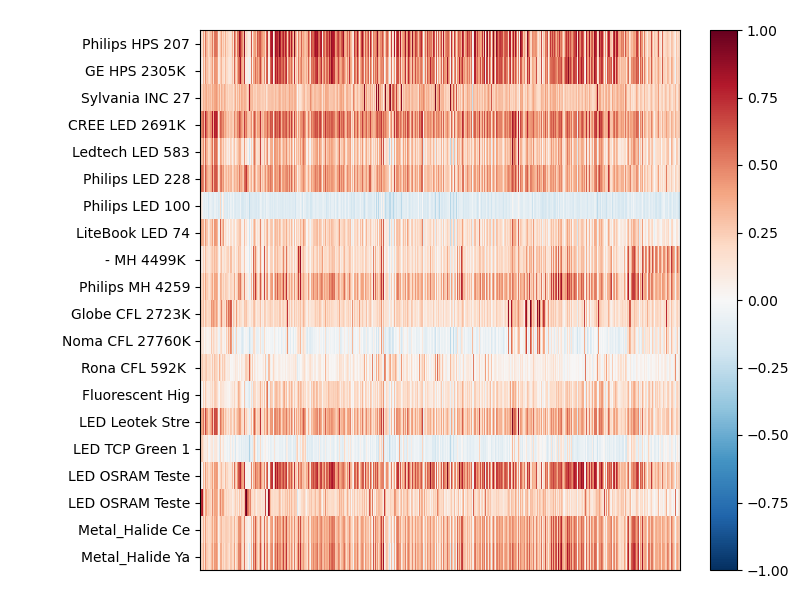

In [24]:
# -- plot the correlation coefficients like Dobler et al. 2016
plt.close("all")
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes((0.25, 0.05, 0.75, 0.9))
im = ax.imshow(ccs.T, aspect="auto", cmap="RdBu_r", clim=[-1, 1])
_ = ax.set_yticks(np.arange(20))
_ = ax.set_yticklabels([i[:15] for i in names])
_ = ax.set_xticks([])
fig.colorbar(im)

In [181]:
# -- count total number
[(names[i], (labs == i).sum()) for i in range(20)]

[('Philips HPS 2079K ', 3089),
 ('GE HPS 2305K ', 330),
 ('Sylvania INC 2787K ', 501),
 ('CREE LED 2691K ', 626),
 ('Ledtech LED 5832K ', 5),
 ('Philips LED 2286K ', 12),
 ('Philips LED 100000000000K ', 0),
 ('LiteBook LED 7462K ', 8),
 ('- MH 4499K ', 540),
 ('Philips MH 4259K ', 220),
 ('Globe CFL 2723K ', 446),
 ('Noma CFL 27760K ', 7),
 ('Rona CFL 592K ', 50),
 ('Fluorescent High CRI', 0),
 ('LED Leotek Streetlight', 85),
 ('LED TCP Green 1W', 6),
 ('LED OSRAM Tester Orange', 801),
 ('LED OSRAM Tester Red', 359),
 ('Metal_Halide Ceramic Metal Halide 100W', 6),
 ('Metal_Halide Yard Blaster', 403)]

In [25]:
# -- get active pixel mask
imgL_hsi0 = np.load("../output/graham_hall_upload/imgL0_overlap.npy")

# -- create active pixel mask
active = np.zeros_like(imgL_hsi0).astype(bool)
active[loc13[:, 0], loc13[:, 1]] = True

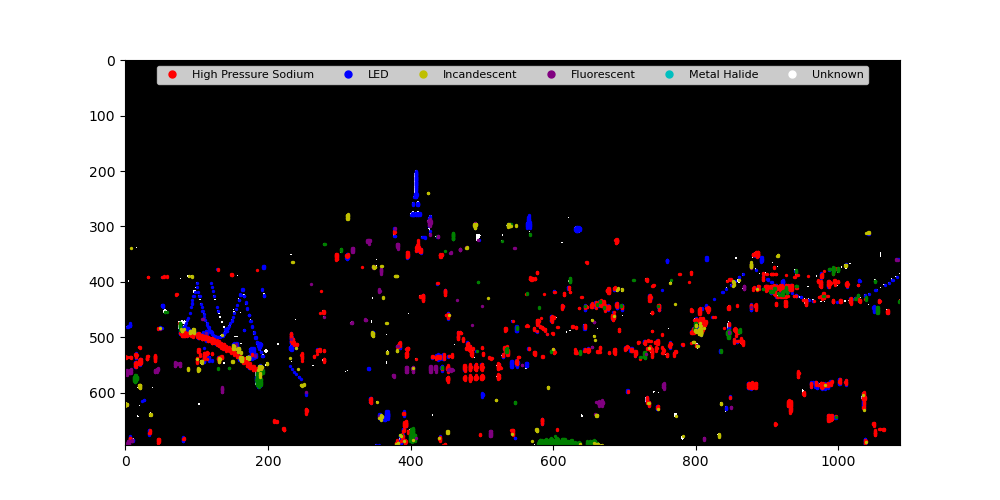

In [40]:
# -- add unknowns to labels
plabs = np.zeros(chisq.size, dtype=int) - 1
plabs[chisq > chisq_thr] = labs

# -- set the colors
clrs = ["r", "r", "y", "b", "b", "b", "b", "b", "g", "g", 
        "purple", "purple", "purple", "purple", "b", "b", "b", "b", "g", "g"]

# -- set the plot order
pord = [3, 4, 5, 6, 7, 14, 15, 16, 17, 0, 1, 8, 9, 18, 19, 10, 11, 12, 13, 2]

# -- plot it
plt.close("all")
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(active, cmap="gist_gray", aspect="auto")
for ii in pord:
    nsrc = (plabs == ii).sum()
    if nsrc > 0:
        ax.scatter(loc13[plabs == ii, 1], loc13[plabs == ii, 0], c=clrs[ii], s=2)
        
# -- make a legend
ax.plot([], [], "r", marker="o", lw=0, label="High Pressure Sodium", ms=5)
ax.plot([], [], "b", marker="o", lw=0, label="LED", ms=5)
ax.plot([], [], "y", marker="o", lw=0, label="Incandescent", ms=5)
ax.plot([], [], "purple", marker="o", lw=0, label="Fluorescent", ms=5)
ax.plot([], [], "c", marker="o", lw=0, label="Metal Halide", ms=5)
ax.plot([], [], "w", marker="o", lw=0, label="Unknown", ms=5)
ax.legend(fontsize=8, ncol=6, loc="upper center")